## What we're going to learn

We're going to go through the follow with TensorFlow:

- Downloading and preparing 10% of the Food101 data (10% of training data)
- Training a feature extraction transfer learning model on 10% of the Food101 training data
- Fine-tuning our feature extraction model
- Saving and loaded our trained model
- Evaluating the performance of our Food Vision model trained on 10% of the training data
  - Finding our model's most wrong predictions
- Making predictions with our Food Vision model on custom images of food

In the previous two notebooks ([transfer learning part 1: feature extraction](https://github.com/ekodavidkurnia/AI-Assistant-Lecturer-2021/blob/master/Transfer%20Learning/04_1_Transfer_Learning_feature_extraction.ipynb) and [part 2: fine-tuning](https://github.com/ekodavidkurnia/AI-Assistant-Lecturer-2021/blob/master/Transfer%20Learning/04_2_Transfer_Learning_Fine_tuning.ipynb)) we've seen the power of transfer learning.

Now we know our smaller modelling experiments are working, it's time to step things up a notch with more data.

This is a common practice in machine learning and deep learning: get a model working on a small amount of data before scaling it up to a larger amount of data.

Our goal is to **beat the original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)'s results with 10% of data**.



## Creating helper function

In [ ]:
# Get the helper function
!wget https://raw.githubusercontent.com/ekodavidkurnia/AI-Assistant-Lecturer-2021/master/helper_functions.py

--2021-09-27 06:48:23--  https://raw.githubusercontent.com/ekodavidkurnia/AI-Assistant-Lecturer-2021/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-27 06:48:23 (63.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## Dataset

In the original [Food101](https://www.kaggle.com/dansbecker/food-101) dataset there's 1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 images.

We could start modelling straight away on this large dataset but in the spirit of continually experimenting, we're going to see how our previously working model's go with 10% of the training data.

This means for each of the 101 food classes we'll be building a model on 75 training images and evaluating it on 250 test images.

In [ ]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2021-09-27 06:48:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 172.217.219.128, 209.85.146.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   203MB/s    in 7.6s    

2021-09-27 06:48:39 (204 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/caprese_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spring_rolls'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/escargots'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pho'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cannoli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/greek_salad'.
There are 0 directories and 250 images in '101_food_class

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [ ]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [ ]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# Get a summary of our model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling (Glob (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
237/237 [==============================] - 152s 485ms/step - loss: 3.4700 - accuracy: 0.2434 - val_loss: 2.6070 - val_accuracy: 0.4383
Epoch 2/5
237/237 [==============================] - 91s 381ms/step - loss: 2.3499 - accuracy: 0.4606 - val_loss: 2.1733 - val_accuracy: 0.4846
Epoch 3/5
237/237 [==============================] - 83s 347ms/step - loss: 1.9838 - accuracy: 0.5246 - val_loss: 2.0167 - val_accuracy: 0.5003
Epoch 4/5
237/237 [==============================] - 78s 324ms/step - loss: 1.7587 - accuracy: 0.5720 - val_loss: 1.9553 - val_accuracy: 0.5032
Epoch 5/5
237/237 [==============================] - 73s 305ms/step - loss: 1.5949 - accuracy: 0.6147 - val_loss: 1.8764 - val_accuracy: 0.5201


Woah! It looks like our model is getting some impressive results, but remember, during training our model only evaluated on 15% of the test data. Let's see how it did on the whole test dataset

In [ ]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 100s 126ms/step - loss: 1.7233 - accuracy: 0.5491


[1.7232677936553955, 0.5490692853927612]

Wohoo!!! its looks like we just **beat the original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)'s results with only 10% of data**. And.... dont forget, its just **under 5 minutes** lol..

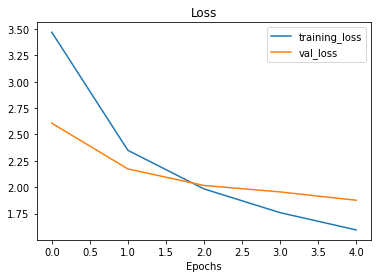

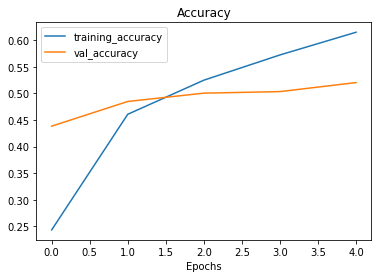

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

Hemmm.. the two curves should be very similar to each other, if not, there may be some overfitting or underfitting.

## Fine Tuning

Since we've got a relatively small training dataset, we'll refreeze every layer except for the last 5, making them trainable.

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [ ]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
history_all_classes_10_percent.epoch[-1]

4

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch

Epoch 5/10
237/237 [==============================] - 83s 316ms/step - loss: 1.3568 - accuracy: 0.6482 - val_loss: 1.9040 - val_accuracy: 0.5093
Epoch 6/10
237/237 [==============================] - 69s 287ms/step - loss: 1.2329 - accuracy: 0.6737 - val_loss: 1.9132 - val_accuracy: 0.5066
Epoch 7/10
237/237 [==============================] - 67s 280ms/step - loss: 1.1538 - accuracy: 0.6924 - val_loss: 1.9413 - val_accuracy: 0.5013
Epoch 8/10
237/237 [==============================] - 66s 278ms/step - loss: 1.0869 - accuracy: 0.7080 - val_loss: 1.8657 - val_accuracy: 0.5180
Epoch 9/10
237/237 [==============================] - 66s 276ms/step - loss: 1.0404 - accuracy: 0.7174 - val_loss: 1.8739 - val_accuracy: 0.5215
Epoch 10/10
237/237 [==============================] - 65s 271ms/step - loss: 0.9675 - accuracy: 0.7428 - val_loss: 1.8724 - val_accuracy: 0.5270


Once again, during training we were only evaluating on a small portion of the test data, let's find out how our model went on all of the test data.

In [ ]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 100s 126ms/step - loss: 1.6279 - accuracy: 0.5724


[1.627924919128418, 0.5724356174468994]

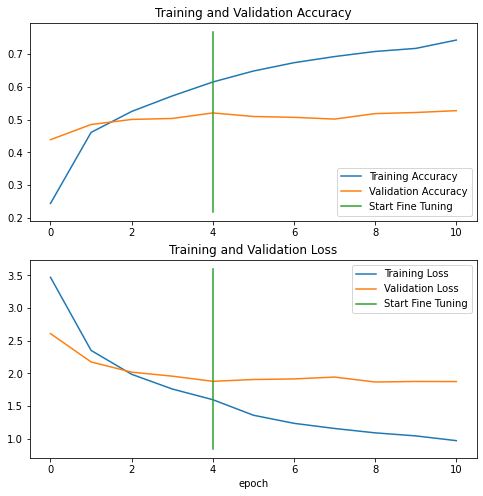

In [ ]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

Looks like our model is starting to overfit. 

This is okay though, its very often the case that fine-tuning leads to overfitting when the data a pre-trained model has been trained on is similar to your custom data.

In our case, our pre-trained model, `EfficientNetB0` was trained on [ImageNet](http://www.image-net.org/index) which contains many real life pictures of food just like our food dataset.

If feautre extraction already works well, the improvements you see from fine-tuning may not be as great as if your dataset was significantly different from the data your base model was pre-trained on.

## Save model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save a model using the SavedModel format
model.save('/content/drive/MyDrive/Dataset/food_class_10_percent_saved_big_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dataset/food_class_10_percent_saved_big_model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# Save a model using the HDF5 format
model.save("food_class_10_percent_saved_big_model.h5") # note the addition of '.h5' on the end

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Making predictions with our trained model

In [ ]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

790/790 [==============================] - 88s 110ms/step


In [ ]:
# How many predictions are there?
len(pred_probs)

25250

In [ ]:
# What's the shape of our predictions?
pred_probs.shape

(25250, 101)

In [ ]:
pred_probs[:10]

array([[4.4684276e-01, 4.6268095e-05, 1.5212744e-01, ..., 2.1174110e-05,
        1.1731969e-03, 3.1419333e-02],
       [9.3338603e-01, 1.1355491e-07, 1.4318047e-03, ..., 1.8818179e-03,
        8.2839745e-07, 2.1647889e-05],
       [2.3167334e-01, 6.5587899e-03, 1.3502256e-02, ..., 4.6594665e-04,
        8.7945309e-04, 1.9520975e-03],
       ...,
       [3.8912424e-01, 3.1152165e-06, 1.4135897e-03, ..., 2.2013212e-02,
        1.8628410e-04, 1.2542277e-04],
       [2.7889794e-01, 2.0267263e-04, 4.8138961e-02, ..., 1.1175453e-04,
        5.5347671e-05, 2.5022027e-04],
       [3.0717510e-01, 3.6774156e-06, 1.1355440e-03, ..., 1.9519968e-02,
        9.9189529e-06, 5.3800689e-03]], dtype=float32)

In [ ]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [4.46842760e-01 4.62680946e-05 1.52127445e-01 1.71629804e-08
 1.56675117e-06 2.75293269e-06 7.62774434e-05 2.39750425e-05
 1.16552701e-02 3.55936383e-04 1.61282958e-06 1.84954683e-06
 1.09979080e-03 2.71651828e-07 1.08928047e-02 3.90050875e-04
 8.64834328e-06 5.99816907e-04 6.94659480e-04 3.95996813e-06
 5.71108103e-05 1.48437284e-05 1.20685268e-04 1.38126008e-04
 3.52442090e-04 1.76884365e-04 1.97321599e-04 4.66684396e-05
 1.97977066e-01 1.85819506e-03 2.94472147e-06 2.71240133e-04
 3.06417875e-04 4.61900349e-08 4.52531455e-03 7.30182228e-06
 6.51586161e-05 2.87169125e-04 9.98549070e-03 6.62844832e-06
 2.04097494e-04 3.47797264e-04 5.58693835e-04 1.99135638e-06
 5.67032021e-06 1.18206581e-05 2.99993582e-04 2.43215283e-04
 2.53498257e-07 9.36015230e-03 1.61437158e-04 1.26260829e-05
 4.27564755e-02 1.88260712e-03 1.06007501e-05 1.00009004e-02
 1.13157704e-02 4.05662984e-04 8.73016752e-

### See the prediction result

In [ ]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0, 38,  8, 78, 29,  0,  9,  0])

### See the actual label

In [ ]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating our models

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.5724356435643564

### Confusion matrix

In [ ]:
# Huhuu.. our helper function cant help in this visualization so lets make another function
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
# Get the class names
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

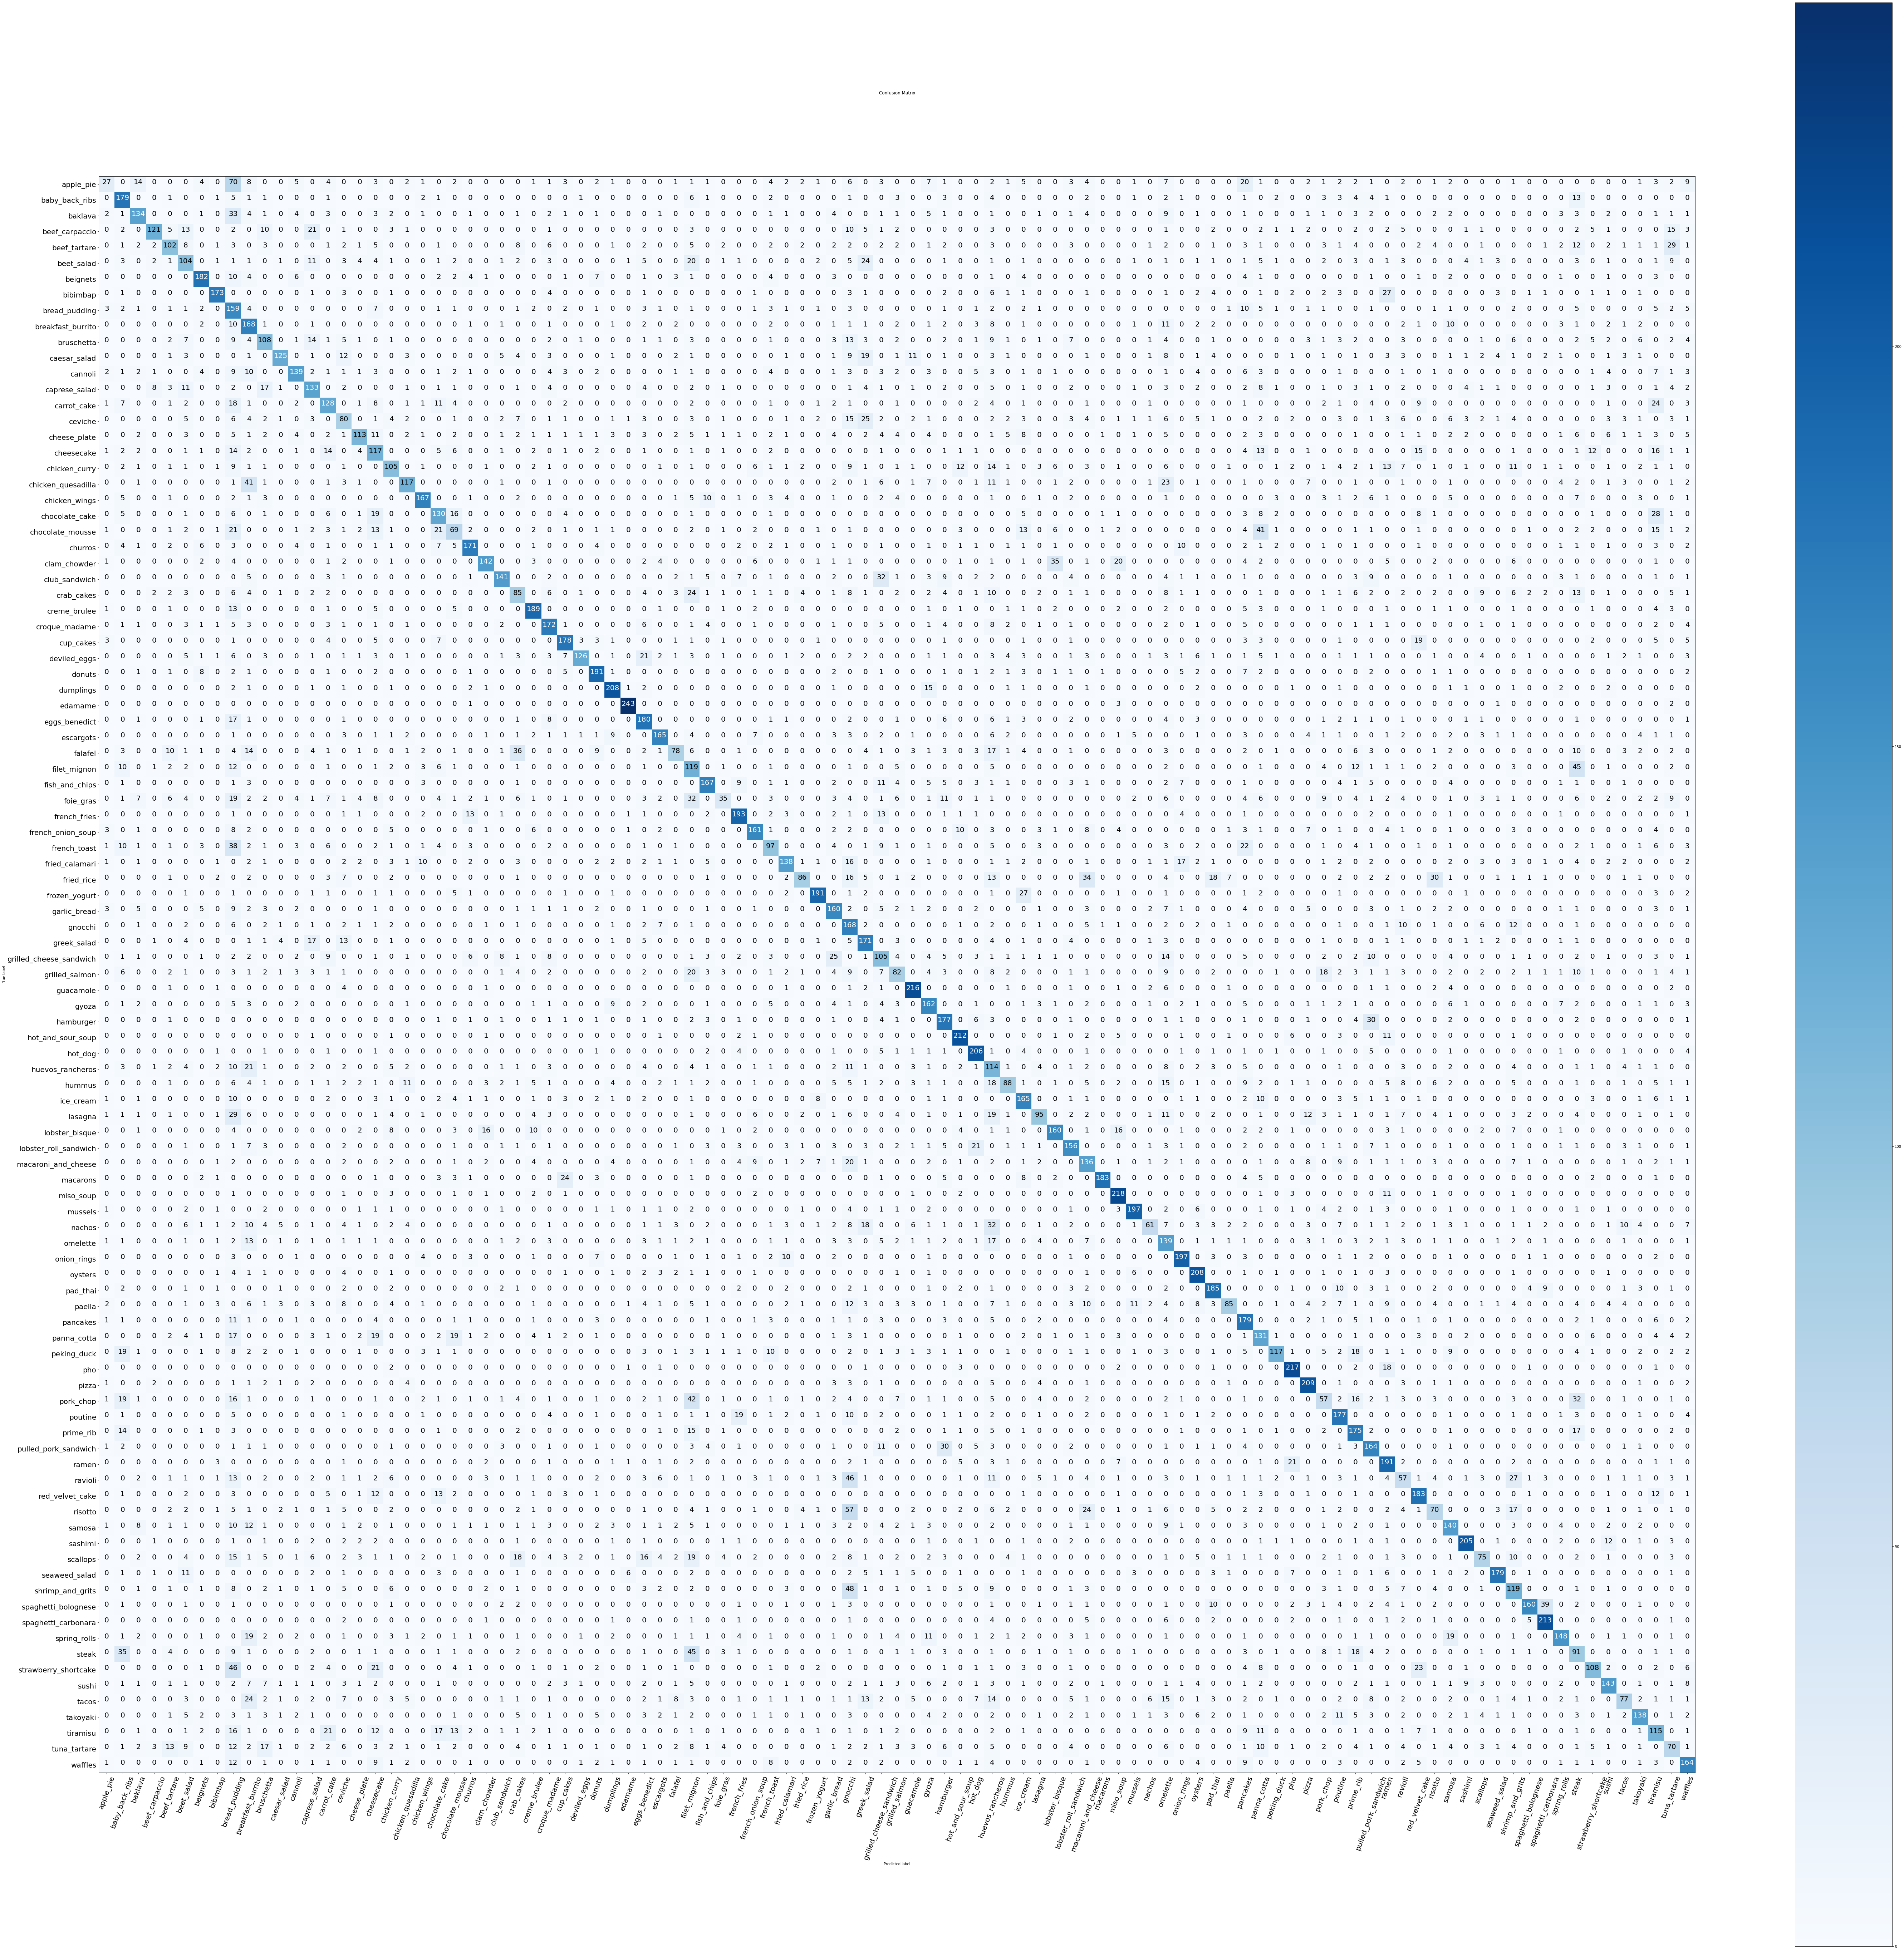

In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

### classification report

In [ ]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.44      0.11      0.17       250
           1       0.51      0.72      0.59       250
           2       0.65      0.54      0.59       250
           3       0.83      0.48      0.61       250
           4       0.57      0.41      0.47       250
           5       0.42      0.42      0.42       250
           6       0.76      0.73      0.74       250
           7       0.85      0.69      0.76       250
           8       0.19      0.64      0.29       250
           9       0.37      0.67      0.48       250
          10       0.47      0.43      0.45       250
          11       0.82      0.50      0.62       250
          12       0.72      0.56      0.63       250
          13       0.51      0.53      0.52       250
          14       0.51      0.51      0.51       250
          15       0.36      0.32      0.34       250
          16       0.71      0.45      0.55       250
          17       0.36    

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.17307692307692307,
  'precision': 0.43548387096774194,
  'recall': 0.108,
  'support': 250},
 '1': {'f1-score': 0.593698175787728,
  'precision': 0.5070821529745042,
  'recall': 0.716,
  'support': 250},
 '10': {'f1-score': 0.45188284518828453,
  'precision': 0.47368421052631576,
  'recall': 0.432,
  'support': 250},
 '100': {'f1-score': 0.6074074074074075,
  'precision': 0.5655172413793104,
  'recall': 0.656,
  'support': 250},
 '11': {'f1-score': 0.6203473945409429,
  'precision': 0.8169934640522876,
  'recall': 0.5,
  'support': 250},
 '12': {'f1-score': 0.6275395033860046,
  'precision': 0.7202072538860104,
  'recall': 0.556,
  'support': 250},
 '13': {'f1-score': 0.5225933202357563,
  'precision': 0.5135135135135135,
  'recall': 0.532,
  'support': 250},
 '14': {'f1-score': 0.5130260521042084,
  'precision': 0.5140562248995983,
  'recall': 0.512,
  'support': 250},
 '15': {'f1-score': 0.33898305084745767,
  'precision': 0.36036036036036034,
  'recall': 0.32,
 

In [ ]:
# Create empty dictionary and get f1-score value
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.17307692307692307,
 'baby_back_ribs': 0.593698175787728,
 'baklava': 0.587719298245614,
 'beef_carpaccio': 0.611111111111111,
 'beef_tartare': 0.4744186046511628,
 'beet_salad': 0.4168336673346693,
 'beignets': 0.7443762781186093,
 'bibimbap': 0.7637969094922736,
 'bread_pudding': 0.2875226039783002,
 'breakfast_burrito': 0.48000000000000004,
 'bruschetta': 0.45188284518828453,
 'caesar_salad': 0.6203473945409429,
 'cannoli': 0.6275395033860046,
 'caprese_salad': 0.5225933202357563,
 'carrot_cake': 0.5130260521042084,
 'ceviche': 0.33898305084745767,
 'cheese_plate': 0.551219512195122,
 'cheesecake': 0.4069565217391304,
 'chicken_curry': 0.4646017699115044,
 'chicken_quesadilla': 0.5611510791366906,
 'chicken_wings': 0.7245119305856834,
 'chocolate_cake': 0.52,
 'chocolate_mousse': 0.3165137614678899,
 'churros': 0.7154811715481171,
 'clam_chowder': 0.6528735632183909,
 'club_sandwich': 0.6497695852534561,
 'crab_cakes': 0.3571428571428571,
 'creme_brulee': 0.75,
 'croq

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
33,edamame,0.958580
63,macarons,0.833713
86,sashimi,0.831643
75,pho,0.828244
51,guacamole,0.821293
...,...,...
8,bread_pudding,0.287523
77,pork_chop,0.276699
82,ravioli,0.264501
39,foie_gras,0.218750


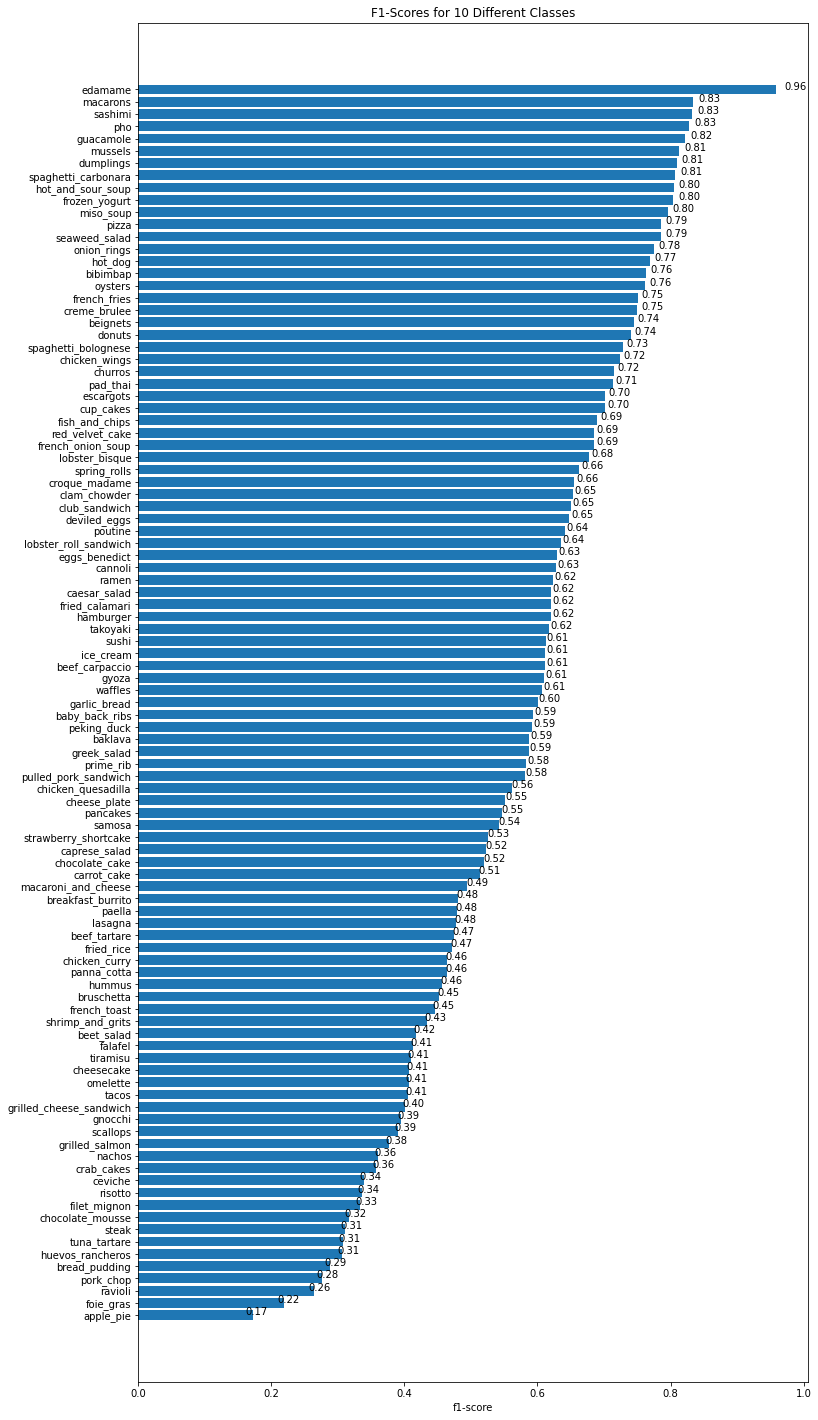

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

It seems like our model performs fairly poorly on classes like `apple_pie` and `ravioli` while for classes like `edamame` and `pho` the performance is quite outstanding.

Findings like these give us clues into where we could go next with our experiments. Perhaps we may have to collect more data on poor performing classes or perhaps the worst performing classes are just hard to make predictions on.

## Visualizing predictions on test images

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

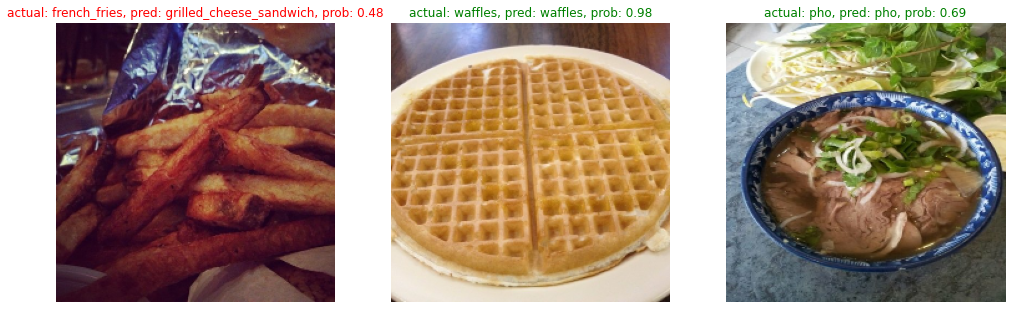

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predicctions

In [ ]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.446843,apple_pie,apple_pie
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.933386,apple_pie,apple_pie
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.231673,apple_pie,apple_pie
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,38,0.218689,apple_pie,fish_and_chips
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,8,0.410049,apple_pie,bread_pudding


In [ ]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.446843,apple_pie,apple_pie,True
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.933386,apple_pie,apple_pie,True
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.231673,apple_pie,apple_pie,True
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,38,0.218689,apple_pie,fish_and_chips,False
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,8,0.410049,apple_pie,bread_pudding,False


In [ ]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
18001,b'101_food_classes_10_percent/test/pancakes/10...,72,67,0.998825,pancakes,omelette,False
23631,b'101_food_classes_10_percent/test/strawberry_...,94,83,0.996979,strawberry_shortcake,red_velvet_cake,False
23797,b'101_food_classes_10_percent/test/sushi/16593...,95,86,0.996651,sushi,sashimi,False
22203,b'101_food_classes_10_percent/test/seaweed_sal...,88,51,0.996563,seaweed_salad,guacamole,False
11642,b'101_food_classes_10_percent/test/garlic_brea...,46,10,0.996470,garlic_bread,bruschetta,False
15826,b'101_food_classes_10_percent/test/macarons/19...,63,29,0.996318,macarons,cup_cakes,False
10847,b'101_food_classes_10_percent/test/fried_calam...,43,68,0.996241,fried_calamari,onion_rings,False
17855,b'101_food_classes_10_percent/test/paella/2314...,71,65,0.995005,paella,mussels,False
22511,b'101_food_classes_10_percent/test/spaghetti_b...,90,78,0.994995,spaghetti_bolognese,poutine,False
10854,b'101_food_classes_10_percent/test/fried_calam...,43,68,0.994795,fried_calamari,onion_rings,False


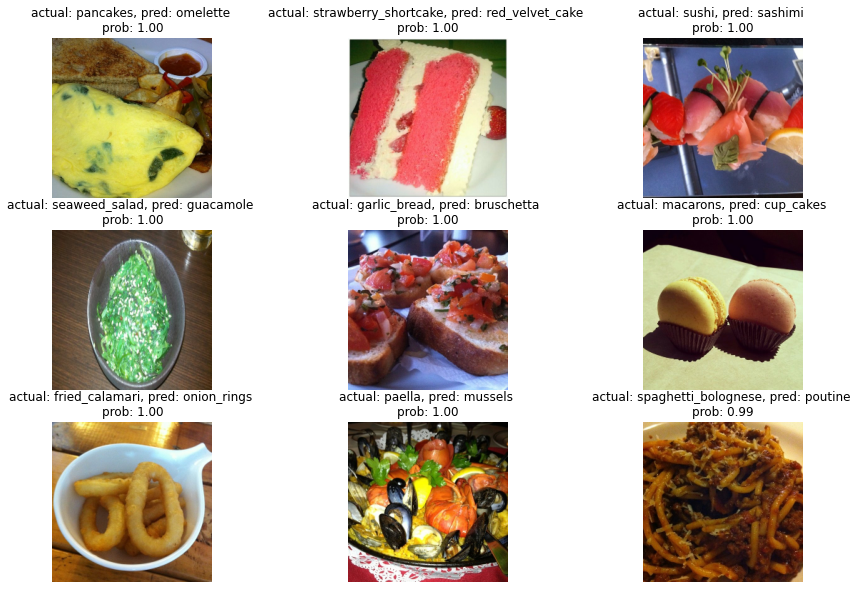

In [ ]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 0 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

After going through the model's most wrong predictions can usually help figure out a couple of things:
* **Some of the labels might be wrong** -  The process of using the model to help improve labels is often referred to as [**active learning**](https://blog.scaleway.com/active-learning-some-datapoints-are-more-equal-than-others/).
* **perhaps it's a good idea to collect more samples on poor labels**